0. setup

In [144]:
import numpy as np

In [145]:
import sys
print(sys.executable)
import numpy
import h5py


/home/johnh/miniconda3/envs/nyuv2_env/bin/python


In [146]:
import numpy, torch, h5py, cv2
import albumentations

print(torch.__version__)
print(torch.cuda.is_available())


2.9.1+cu130
True


1. Data loading and exploration

In [147]:
import h5py
from pathlib import Path
import os
# from dotenv import load_dotenv

# load_dotenv()

DATA_PATH = Path("./data")
nyu = DATA_PATH / "nyu_depth_v2_labeled.mat"

# Exploring the keys and structure of h5py files
with h5py.File(nyu, 'r') as f:  
    print(f"Top-level keys in the file: {list(f.keys())}")  
    for key in f.keys():
        item = f[key]
        print(f"****\nInspecting key {key} \n****")
        if isinstance(item, h5py.Dataset):
            print(f"  - Type:Dataset")
            print(f"  Shape: {item.shape}")
            print(f"  - Data type(dtype): {item.dtype}")
        elif isinstance(item, h5py.Group):
            print(f"  - Type: Group")
            print(f"  - Keys within this group: {list(item.keys())}")


f = h5py.File(nyu, 'r')
print(list(f.keys()))


Top-level keys in the file: ['#refs#', '#subsystem#', 'accelData', 'depths', 'images', 'instances', 'labels', 'names', 'namesToIds', 'rawDepthFilenames', 'rawDepths', 'rawRgbFilenames', 'sceneTypes', 'scenes']
****
Inspecting key #refs# 
****
  - Type: Group
  - Keys within this group: ['0', '00', '00b', '01', '01b', '02', '02b', '03', '03b', '04', '04b', '05', '05b', '06', '06b', '07', '07b', '08', '08b', '09', '09b', '0A', '0Ab', '0B', '0Bb', '0C', '0Cb', '0D', '0Db', '0E', '0Eb', '0F', '0Fb', '0G', '0Gb', '0H', '0Hb', '0I', '0Ib', '0J', '0Jb', '0K', '0Kb', '0L', '0Lb', '0M', '0Mb', '0N', '0Nb', '0O', '0Ob', '0P', '0Pb', '0Q', '0Qb', '0R', '0Rb', '0S', '0Sb', '0T', '0Tb', '0U', '0Ub', '0V', '0Vb', '0W', '0Wb', '0X', '0Xb', '0Y', '0Yb', '0Z', '0Zb', '0ab', '0ac', '0b', '0bb', '0bc', '0c', '0cb', '0cc', '0d', '0db', '0dc', '0e', '0eb', '0ec', '0f', '0fb', '0fc', '0g', '0gb', '0gc', '0h', '0hb', '0hc', '0i', '0ib', '0ic', '0j', '0jb', '0jc', '0k', '0kb', '0kc', '0l', '0lb', '0lc', '0m',

In [148]:
for key in f.keys():
    print(key)
    

#refs#
#subsystem#
accelData
depths
images
instances
labels
names
namesToIds
rawDepthFilenames
rawDepths
rawRgbFilenames
sceneTypes
scenes


In [149]:
f["#subsystem#"]

<HDF5 group "/#subsystem#" (1 members)>

In [150]:
f["labels"][0, 45:50, 45:50]


array([[21, 21, 21, 21, 21],
       [21, 21, 21, 21, 21],
       [21, 21, 21, 21, 21],
       [21, 21, 21, 21, 21],
       [21, 21, 21, 21, 21]], dtype=uint16)

In [151]:
print(f["namesToIds"].shape)
for value in f["namesToIds"]:
    print(value)

(1, 6)
[3707764736          2          1          1          1          1]


In [152]:
# loipon to names.. ton pairnei.. mallon pame me to labels pros to paron pou exei 22 klaseis kathares

# names_references = f["names"]
# type(names_references)
# actual_names = []
# for ref in names_references[0].ravel():
#     target = f[ref]
#     name_string = ''.join(chr(c) for c in target)
#     actual_names.append(name_string)
# for name in actual_names[:10]:
#     print(name)

In [153]:
# WILL Review this code later.. chatgpt.. wrote it
# First, let's explore what the references actually point to
names_references = f["names"]
actual_names = []

print(f"Names references shape: {names_references.shape}")
print(f"First few references: {names_references[0, :5]}")

# Try to access and read the referenced datasets properly
for i, ref in enumerate(names_references[0].ravel()):
    try:
        target = f[ref]  # This is an HDF5 dataset, not a numpy array yet
        
        # Check what type it is
        if isinstance(target, h5py.Dataset):
            # Read the actual data from the dataset
            data = target[:]  # Read the entire dataset
            print(f"Reference {i}: shape={data.shape}, dtype={data.dtype}")
            
            # Handle different data types
            if data.dtype in [np.uint8, np.int8, np.uint16, np.int16]:
                # Flatten if needed and convert to characters
                data_flat = data.flatten()
                name_string = ''.join(chr(int(c)) for c in data_flat)
            elif data.dtype == object:
                # If it's object type, might need different handling
                name_string = str(data)
            else:
                # Try to decode as UTF-8
                try:
                    name_string = data.tobytes().decode('utf-8').rstrip('\x00')
                except:
                    name_string = ''.join(chr(int(c)) for c in data.flatten())
            
            actual_names.append(name_string)
            
            # Print first few to see if it's working
            if i < 5:
                print(f"  Decoded name: {name_string}")
        else:
            print(f"Reference {i}: Not a dataset, type={type(target)}")
            actual_names.append(str(target))
            
    except Exception as e:
        print(f"Error processing reference {i}: {e}")
        actual_names.append(f"ERROR_{i}")

print(f"\nTotal names extracted: {len(actual_names)}")
print("\nFirst 10 class names:")
for i, name in enumerate(actual_names[:10]):
    print(f"  {i}: {name}")

Names references shape: (1, 894)
First few references: [<HDF5 object reference> <HDF5 object reference> <HDF5 object reference>
 <HDF5 object reference> <HDF5 object reference>]
Reference 0: shape=(4, 1), dtype=uint16
  Decoded name: book
Reference 1: shape=(6, 1), dtype=uint16
  Decoded name: bottle
Reference 2: shape=(7, 1), dtype=uint16
  Decoded name: cabinet
Reference 3: shape=(7, 1), dtype=uint16
  Decoded name: ceiling
Reference 4: shape=(5, 1), dtype=uint16
  Decoded name: chair
Reference 5: shape=(4, 1), dtype=uint16
Reference 6: shape=(7, 1), dtype=uint16
Reference 7: shape=(10, 1), dtype=uint16
Reference 8: shape=(6, 1), dtype=uint16
Reference 9: shape=(17, 1), dtype=uint16
Reference 10: shape=(5, 1), dtype=uint16
Reference 11: shape=(11, 1), dtype=uint16
Reference 12: shape=(9, 1), dtype=uint16
Reference 13: shape=(21, 1), dtype=uint16
Reference 14: shape=(5, 1), dtype=uint16
Reference 15: shape=(3, 1), dtype=uint16
Reference 16: shape=(13, 1), dtype=uint16
Reference 17: sh

In [154]:
IDX_EXPLORE = int(441617065/640/480)

In [155]:
images = f['images']
depths = f['depths']
labels = f['labels']

print("Images shape:", images.shape, " and type: ", images.dtype, type(images))
print("Depths shape:", depths.shape, " and type: ", depths.dtype, type(depths))
print("Labels shape:", labels.shape, " and type: ", labels.dtype, type(labels))
print("Number of samples:", images.shape[0])

Images shape: (1449, 3, 640, 480)  and type:  uint8 <class 'h5py._hl.dataset.Dataset'>
Depths shape: (1449, 640, 480)  and type:  float32 <class 'h5py._hl.dataset.Dataset'>
Labels shape: (1449, 640, 480)  and type:  uint16 <class 'h5py._hl.dataset.Dataset'>
Number of samples: 1449


In [183]:
len(f["#refs#"].keys())

8484

In [184]:
f["names"].dtype, f["names"].shape


(dtype('O'), (1, 894))

In [186]:
def decode_matlab_string(arr):
    # arr is a numpy array of char codes
    arr = arr.flatten()
    return "".join(chr(c) for c in arr if c != 0)


In [192]:
len(np.unique(labels))

895

In [193]:
names = []

for ref in f["names"][0]:
    s = f[ref][()]
    name = decode_matlab_string(s)
    names.append(name)

len(names), names[68:100]


(894,
 ['folder',
  'jar',
  'magazine',
  'ruler',
  'cable modem',
  'fan',
  'file',
  'hand sanitizer',
  'paper rack',
  'vase',
  'air conditioner',
  'blinds',
  'flower',
  'plant',
  'sofa',
  'stereo',
  'books',
  'exit sign',
  'room divider',
  'bookshelf',
  'curtain',
  'projector',
  'modem',
  'wire',
  'water purifier',
  'column',
  'hooks',
  'hanging hooks',
  'pen',
  'electrical outlet',
  'doll',
  'eraser'])

In [196]:
semantic_names = [n.split('_')[0] for n in names]
unique_semantic_names = list(set(semantic_names))
print(len(unique_semantic_names))
print(unique_semantic_names)


894
['modem', 'suitcase', 'serving spoon', 'dish scrubber', 'cleaning wipes', 'travel bag', 'toyhouse', 'blanket', 'clothing dryer', 'pen holder', 'bottle of contact lens solution', 'tuna cans', 'bag of bagels', 'bookend', 'lid of jar', 'clothing washer', 'tea cannister', 'dvd player', 'dollar bill', 'photo', 'music stand', 'paper towel', 'lint roller', 'lamp shade', 'plate', 'router', 'toaster', 'butterfly sculpture', 'curtain rod', 'case', 'waffle maker', 'vasoline', 'tree sculpture', 'toothbrush', 'tray', 'toy pyramid', 'gold piece', 'toys basket', 'bicycle', 'jacket', 'chalkboard', 'toilet bowl brush', 'ping pong ball', 'head phone', 'faucet', 'towel rod', 'wire board', 'mens suit', 'shower pipe', 'watermellon', 'dishes', 'salt and pepper', 'excercise ball', 'bottle of soap', 'bed', 'sink protector', 'vegetable peeler', 'mug hanger', 'framed certificate', 'trophy', 'squeeze tube', 'pan', 'cooking pot cover', 'toy sofa', 'fish tank', 'telescope', 'placard', 'sock', 'can opener', 'dv

In [157]:
np.unique(np.array(labels[int(441617065/640/480)]))

array([  0,   1,   3,  11,  21,  42,  55,  59,  64,  78, 129, 148, 191,
       301, 894], dtype=uint16)

In [158]:
print("The type of first image is: ", type(images[IDX_EXPLORE]), images[IDX_EXPLORE].dtype)

The type of first image is:  <class 'numpy.ndarray'> uint8


The structure seems to be (N_Samples, channels*, width, height)

In [159]:
print(np.unique(labels[IDX_EXPLORE]), labels[IDX_EXPLORE].shape)
print("Number of classes: ", len(np.unique(labels[IDX_EXPLORE])))

[  0   1   3  11  21  42  55  59  64  78 129 148 191 301 894] (640, 480)
Number of classes:  15


We see 22 unique labels

In [160]:
all_classes_names = f['names']
print(type(all_classes_names[0]))
print("Label names: ", all_classes_names)

<class 'numpy.ndarray'>
Label names:  <HDF5 dataset "names": shape (1, 894), type "|O">


In [161]:
print("Depth min/max:", depths[0, :, :].min(), depths[0, :, :].max())


Depth min/max: 1.7985953 3.615639


In [162]:
print("Labels unique values:", set(labels[0, :, :].flatten()))

Labels unique values: {np.uint16(0), np.uint16(1), np.uint16(2), np.uint16(3), np.uint16(4), np.uint16(5), np.uint16(6), np.uint16(7), np.uint16(8), np.uint16(9), np.uint16(10), np.uint16(11), np.uint16(12), np.uint16(13), np.uint16(14), np.uint16(15), np.uint16(16), np.uint16(17), np.uint16(18), np.uint16(19), np.uint16(20), np.uint16(21)}


In [163]:
import numpy as np


rgb = np.array(images[IDX_EXPLORE, :, :, :], dtype=np.uint8)
depth = np.array(depths[IDX_EXPLORE, :, :], dtype=np.float32)
label = np.array(labels[IDX_EXPLORE, :, :], dtype=np.int32)

rgb.shape, depth.shape, label.shape

((3, 640, 480), (640, 480), (640, 480))

In [164]:
rgb[0, :5]

array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], shape=(5, 480), dtype=uint8)

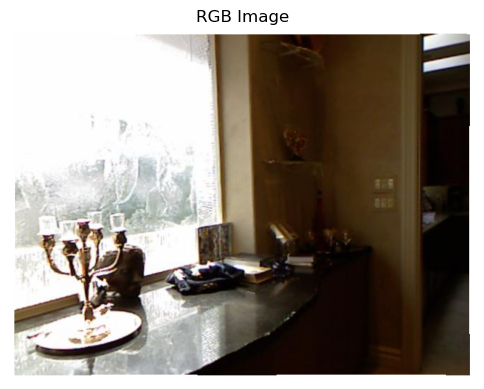

In [165]:
import matplotlib.pyplot as plt

rgb_hwc = np.transpose(rgb, (2, 1, 0))


plt.figure(figsize=(6,6))
plt.imshow(rgb_hwc.astype(np.uint8))
plt.title("RGB Image")
plt.axis('off')
plt.show()


In [166]:
label.shape

(640, 480)

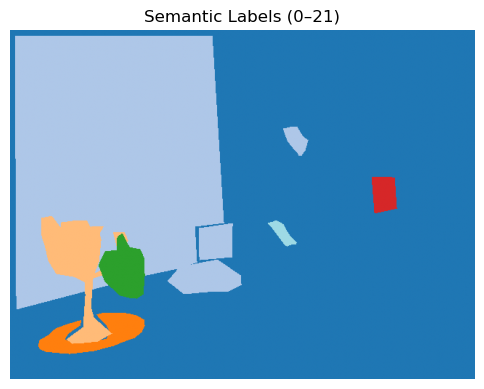

In [167]:
import matplotlib.pyplot as plt


# label_t = np.transpose(label, (2, 1, 0))

plt.figure(figsize=(6,6))
plt.imshow(label.T, cmap='tab20')  # categorical colormap for 20+ classes
# plt.colorbar()
plt.title("Semantic Labels (0–21)")
plt.axis('off')
plt.show()


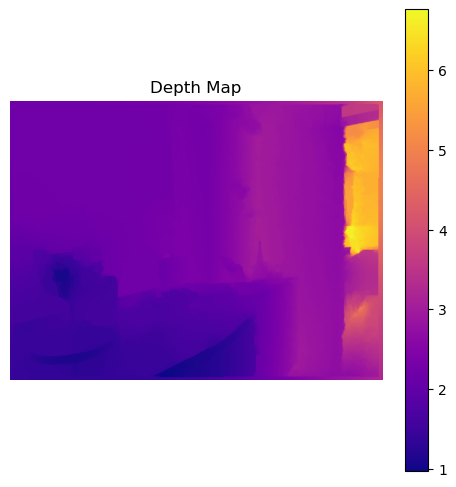

In [168]:
plt.figure(figsize=(6,6))
plt.imshow(depth.T, cmap='plasma')
plt.colorbar()
plt.title("Depth Map")
plt.axis('off')
plt.show()

Label ID → Class Name Mapping:
   0 → book
   1 → bottle
   2 → cabinet
   3 → ceiling
   4 → chair
   5 → cone
   6 → counter
   7 → dishwasher
   8 → faucet
   9 → fire extinguisher
  10 → floor
  11 → garbage bin
  12 → microwave
  13 → paper towel dispenser
  14 → paper
  15 → pot
  16 → refridgerator
  17 → stove burner
  18 → table
  19 → unknown
  20 → wall
  21 → bowl
  22 → magnet
  23 → sink
  24 → air vent
  25 → box
  26 → door knob
  27 → door
  28 → scissor
  29 → tape dispenser
  30 → telephone cord
  31 → telephone
  32 → track light
  33 → cork board
  34 → cup
  35 → desk
  36 → laptop
  37 → air duct
  38 → basket
  39 → camera
  40 → pipe
  41 → shelves
  42 → stacked chairs
  43 → styrofoam object
  44 → whiteboard
  45 → computer
  46 → keyboard
  47 → ladder
  48 → monitor
  49 → stand
  50 → bar
  51 → motion camera
  52 → projector screen
  53 → speaker
  54 → bag
  55 → clock
  56 → green screen
  57 → mantel
  58 → window
  59 → ball
  60 → hole puncher
  61 

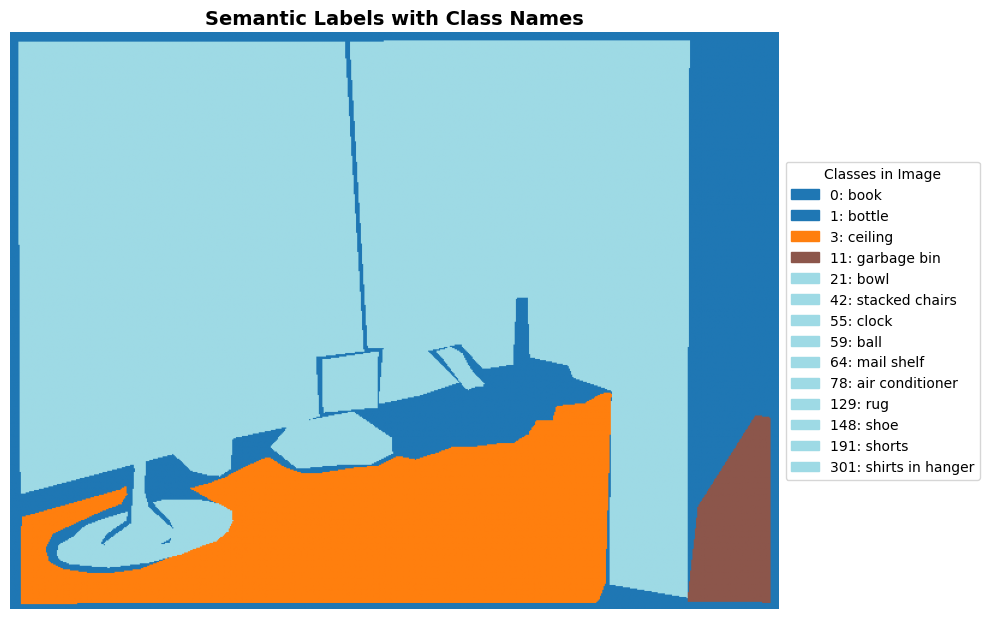

In [169]:
# Step 1: Extract class names and create ID → Name mapping
names_references = f["names"]
class_names = []

# Extract first 22 names (since you have 22 classes: 0-21)
for i, ref in enumerate(names_references[0].ravel()[:]):
    try:
        target = f[ref]
        data = target[:]
        if data.dtype in [np.uint8, np.int8, np.uint16, np.int16]:
            data_flat = data.flatten()
            name_string = ''.join(chr(int(c)) for c in data_flat)
        else:
            name_string = data.tobytes().decode('utf-8').rstrip('\x00')
        class_names.append(name_string)
    except Exception as e:
        class_names.append(f"class_{i}")

# Create mapping dictionary: {label_id: class_name}
label_to_name = {i: class_names[i] for i in range(len(class_names))}

# Print the mapping to see it
print("Label ID → Class Name Mapping:")
print("=" * 40)
for label_id, name in label_to_name.items():
    print(f"  {label_id:2d} → {name}")
print("=" * 40)

# Step 2: Enhanced visualization with class names
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Get unique labels in current image
label = np.array(labels[IDX_EXPLORE, :, :], dtype=np.int32)
unique_labels = np.unique(label)

# Create the plot with legend
fig, ax = plt.subplots(figsize=(10, 8))

# Plot the label map
im = ax.imshow(label.T, cmap='tab20', vmin=0, vmax=21)
ax.set_title("Semantic Labels with Class Names", fontsize=14, fontweight='bold')
ax.axis('off')

# Create legend showing only classes present in this image
legend_patches = []
for label_id in sorted(unique_labels):
    if label_id in label_to_name:
        # Get color from colormap
        color = plt.cm.tab20(label_id / 21)  # Normalize to [0,1]
        # Create patch with label ID and name
        patch = mpatches.Patch(
            color=color, 
            label=f"{label_id}: {label_to_name[label_id]}"
        )
        legend_patches.append(patch)

# Add legend
ax.legend(
    handles=legend_patches, 
    loc='center left', 
    bbox_to_anchor=(1, 0.5),
    fontsize=10,
    title="Classes in Image"
)

plt.tight_layout()
plt.show()

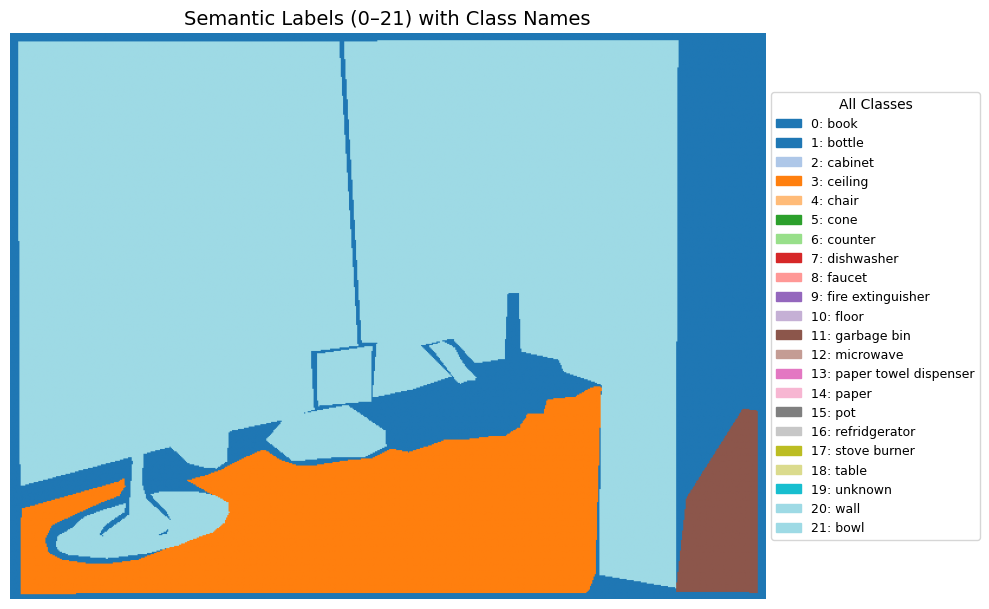

In [170]:
# Simpler version: Show all 22 classes in legend
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Use the label_to_name mapping from above
label = np.array(labels[IDX_EXPLORE, :, :], dtype=np.int32)

fig, ax = plt.subplots(figsize=(10, 8))
im = ax.imshow(label.T, cmap='tab20', vmin=0, vmax=21)
ax.set_title("Semantic Labels (0–21) with Class Names", fontsize=14)
ax.axis('off')

# Create legend for ALL 22 classes
legend_patches = []
for label_id in range(22):  # All classes 0-21
    color = plt.cm.tab20(label_id / 21)
    patch = mpatches.Patch(
        color=color,
        label=f"{label_id}: {label_to_name[label_id]}"
    )
    legend_patches.append(patch)

ax.legend(
    handles=legend_patches,
    loc='center left',
    bbox_to_anchor=(1, 0.5),
    fontsize=9,
    title="All Classes"
)

plt.tight_layout()
plt.show()

In [171]:
# visualize or see the numbers on the image to see how each class is represented


## train and test split indices

In [172]:
#TODO: create new paths if needed
#TODO: save .npy files and load them 
#TODO: use albumentations and find out its power


## Create the Dataset Class

In [173]:
#TODO: Turn data into Tensor
#TODO: Set some Transforms, -> decide which to put inside the Class or before and find libraries